# Python libraries for doing statistics

see draft here: https://docs.google.com/document/d/1a-Ohl3hs7w8AiOr85PxW0DZP1ofFK02sk55IEw0zQPE/edit?tab=t.0


Click [here](https://mybinder.org/v2/gh/minireference/noBSstats/HEAD?urlpath=%2Fdoc%2Ftree%2Fblogposts%2Fstats_procedures.ipynb)
to run the notebook interactively,
so you can play with the code examples.

### Notebook setup

In [1]:
# Install stats library
%pip install --quiet ministats 


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Figures setup
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()  # needed otherwise `sns.set_theme` doesn't work
sns.set_theme(
    style="whitegrid",
    rc={'figure.figsize': (7, 2)},
)
# High-resolution figures please
%config InlineBackend.figure_format = 'retina'

def savefig(fig, filename):
    fig.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0)

<Figure size 640x480 with 0 Axes>

## Introduction

### IQ scores sample

Consider the following dataset,
which consists of IQ scores of 30 students who took a "smart drug" ☕.
The IQ scores are recorded in the following list.

In [3]:
iqs = [ 95.7, 100.1,  95.3, 100.7, 123.5, 119.4,  84.4, 109.6,
       108.7,  84.7, 111.0,  92.1, 138.4, 105.2,  97.5, 115.9,
       104.4, 105.6, 104.8, 110.8,  93.8, 106.6,  71.3, 130.6,
       125.7, 130.2, 101.2, 109.0, 103.8,  96.7]

In [4]:
# data

treated = [92.69, 117.15, 124.79, 100.57, 104.27, 121.56, 104.18,
           122.43, 98.85, 104.26, 118.56, 138.98, 101.33, 118.57, 
           123.37, 105.9, 121.75, 123.26, 118.58, 80.03, 121.15, 
           122.06, 112.31, 108.67, 75.44, 110.27, 115.25, 125.57,
           114.57, 98.09, 91.15, 112.52, 100.12, 115.2, 95.32, 
           121.37, 100.09, 113.8, 101.73, 124.9, 87.83, 106.22, 
           99.97, 107.51, 83.99, 98.03, 71.91, 109.99, 90.83, 105.48]

controls = [85.1, 84.05, 90.43, 115.92, 97.64, 116.41, 68.88, 110.51, 
            125.12, 94.04, 134.86, 85.0, 91.61, 69.95, 94.51, 81.16, 
            130.61, 108.93, 123.38, 127.69, 83.36, 76.97, 124.87, 86.36, 
            105.71, 93.01, 101.58, 93.58, 106.51, 91.67, 112.93, 88.74, 
            114.05, 80.32, 92.91, 85.34, 104.01, 91.47, 109.2, 104.04, 
            86.1, 91.52, 98.5, 94.62, 101.27, 107.41, 100.68, 114.94, 
            88.8, 121.8]


## Statistics procedures as readable code (ministats)

### Generating sampling distributions

In [5]:
from ministats import gen_sampling_dist

%psource gen_sampling_dist

def gen_sampling_dist(rv, estfunc, n, N=10000):
    """
    Simulate `N` samples of size `n` from the random variable `rv`
    to generate the sampling distribution of the estimator `estfunc`.
    """
    estimates = []
    for j in range(N):
        sample = rv.rvs(n)
        estimate = estfunc(sample)
        estimates.append(estimate)
    return estimates


### One-sample t-test for the mean

In [6]:
from ministats import ttest_mean
%psource ttest_mean

def ttest_mean(sample, mu0, alt="two-sided"):
    """
    T-test to detect mean deviation from a population with known mean `mu0`.
    """
    assert alt in ["greater", "less", "two-sided"]
    obsmean = np.mean(sample)
    n = len(sample)
    std = np.std(sample, ddof=1)
    sehat = std / np.sqrt(n)
    obst = (obsmean - mu0) / sehat
    rvT = tdist(df=n-1)
    pvalue = tailprobs(rvT, obst, alt=alt)
    return pvalue


In [7]:
ttest_mean(iqs, mu0=100, alt="greater")

np.float64(0.01792942680682752)

### Generating bootstrap distributions

In [8]:
from ministats import gen_boot_dist

%psource gen_boot_dist

def gen_boot_dist(sample, estfunc, B=5000):
    """
    Generate estimates from the sampling distribution of the estimator `estfunc`
    based on `B` bootstrap samples (sampling with replacement) from `sample`.
    """
    n = len(sample)
    bestimates = []
    for j in range(B):
        bsample = np.random.choice(sample, n, replace=True)
        bestimate = estfunc(bsample)
        bestimates.append(bestimate)
    return bestimates


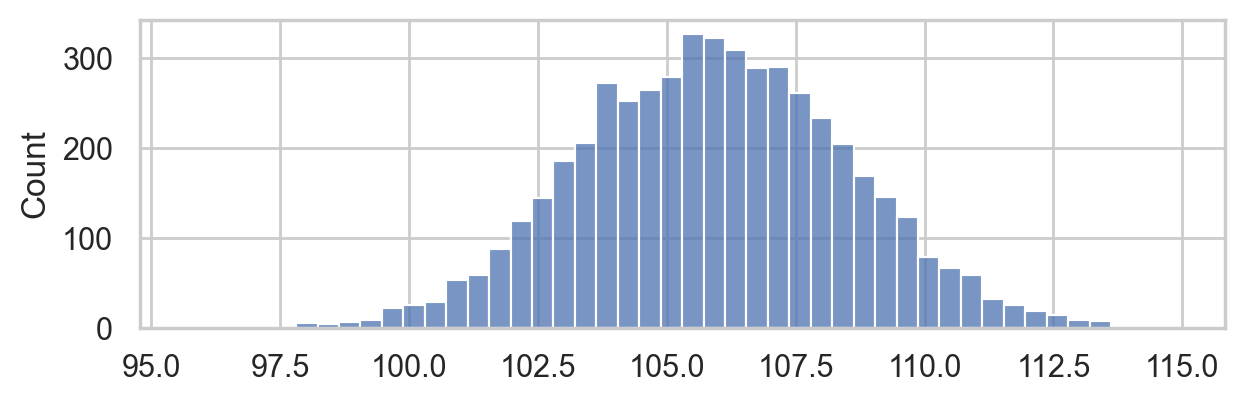

In [9]:
import numpy as np
iqs_boot = gen_boot_dist(iqs, estfunc=np.mean)
sns.histplot(iqs_boot);

### The permutation test for comparing two groups

In [10]:
from ministats.hypothesis_tests import resample_under_H0
from ministats import permutation_test_dmeans

%psource permutation_test_dmeans

def permutation_test_dmeans(xsample, ysample, P=10000):
    """
    Compute the p-value of the observed difference between means
    `dmeans(xsample,ysample)` under the null hypothesis where
    the group membership is randomized.
    """
    # 1. Compute the observed difference between means
    obsdhat = dmeans(xsample, ysample)

    # 2. Get sampling dist. of `dmeans` under H0
    pdhats = []
    for i in range(0, P):
        rsx, rsy = resample_under_H0(xsample, ysample)
        pdhat = dmeans(rsx, rsy)
        pdhats.append(pdhat)

    # 3. Compute the p-value
    tails = tailvalues(pdhats, obsdhat)
    pvalue = len(tails) / len(pdhats)
    return pvalue


In [11]:
%psource resample_under_H0

def resample_under_H0(xsample, ysample):
    """
    Generate new samples from a random permutation of
    the values in the samples `xsample` and `ysample`.
    """
    values = np.concatenate((xsample, ysample))
    shuffled_values = np.random.permutation(values)
    xresample = shuffled_values[0:len(xsample)]
    yresample = shuffled_values[len(xsample):]
    return xresample, yresample


In [12]:
np.random.seed(43)
permutation_test_dmeans(treated, controls)

0.0098


See the [`ministats`](https://github.com/minireference/ministats/tree/main/ministats) library
for more examples of Python functions that implement the statistical procedures in STATS 101.

In the past, students first contact with statistics was presented as a bunch of procedures
without explanation, and students were supposed to memorize when to use which "recipe".
Statistics instructors always had to "skip the details" because it's super complicated to
explain all the details (probability models, sampling distributions, p-value calculations, etc.).

Now that we have Python on our side, we don't have to water-down the material,
but can instead show all the detailed calculations for statistical tests,
as easy-to-understand Python source code, which makes it much much easier to understand what is going on.
Currently,
the [`ministats`](https://github.com/minireference/ministats/tree/main/ministats) library contains about 400 lines of code.
With a little bit of Python knowledge,
you can read the source code and understand all of statistics.

## Conclusion

## Links